In [1]:
import numpy as np
# Experiment with Iris Dataset

import pandas as pd
from code.utils import load_data, plot_clusters, display_and_save_metrics_table, calculate_metrics
from code.clustering import run_kmeans, elbow_method, align_labels_and_centroids
from code.post_processing import detect_misclassified_with_silhouette, post_process_with_rf, \
    split_stable_and_misclassified

In [2]:
data_path = "../data/Iris-150.txt"
data, encoded_labels, label_mapping = load_data(data_path)

# Assign original_labels for metric calculations
original_labels: np.ndarray = encoded_labels  # Use the numeric-encoded labels for calculations

print("Label Mapping:")
print(label_mapping)


Label Mapping:
{'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}


Running Elbow Method...


C:\Users\User\Desktop\facultate\master\an1\BDA\BDA_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\User\Desktop\facultate\master\an1\BDA\BDA_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec

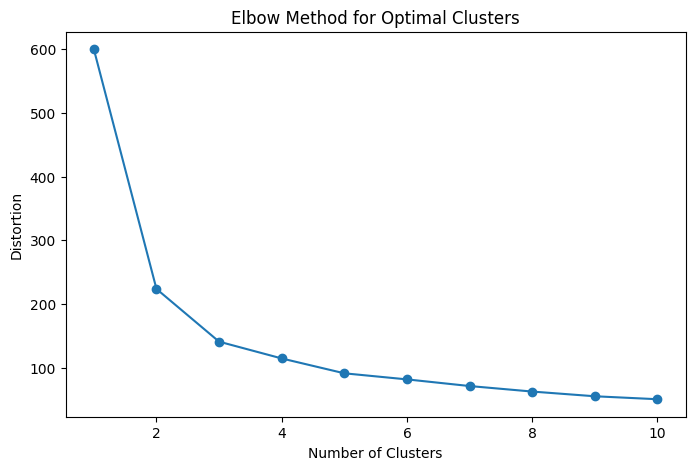

In [3]:
# Elbow method to find optimal clusters
print("Running Elbow Method...")
elbow_method(data, output_path="../results/iris/elbow_method.png")


In [4]:
# Run K-Means clustering
optimal_clusters = 3  # Replace with optimal number determined from elbow plot
print(f"Running K-Means with {optimal_clusters} clusters...")
kmeans_model, cluster_labels = run_kmeans(data, optimal_clusters)
centroids = kmeans_model.cluster_centers_

# Align cluster labels and centroids
cluster_labels, centroids = align_labels_and_centroids(
    true_labels=original_labels,
    cluster_labels=cluster_labels,
    centroids=centroids
)

# Verify the alignment
print("Aligned Cluster Labels (first 10):", cluster_labels[:10])
print("Aligned Centroids:", centroids)

Running K-Means with 3 clusters...
Aligned Cluster Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Aligned Centroids: [[-1.01457897  0.84230679 -1.30487835 -1.25512862]
 [-0.05021989 -0.88029181  0.34753171  0.28206327]
 [ 1.13597027  0.09659843  0.996271    1.01717187]]


Visualizing initial K-Means clustering...


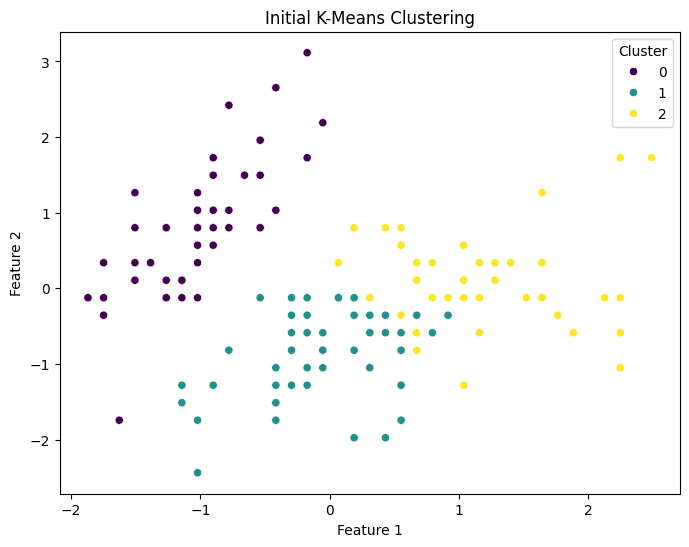

In [5]:
# Plot initial K-Means clustering results
print("Visualizing initial K-Means clustering...")
plot_clusters(data, cluster_labels, "Initial K-Means Clustering", "../results/iris/initial_kmeans.png")

In [6]:
# Calculate K-Means metrics
kmeans_metrics = calculate_metrics(original_labels, cluster_labels)
print(f"K-Means Metrics: {kmeans_metrics}")

K-Means Metrics: {'precision': 0.8339355011374281, 'recall': 0.8333333333333334, 'accuracy': 0.8333333333333334}


In [7]:
# Convert cluster_labels to pd.Series for compatibility
cluster_labels = pd.Series(cluster_labels, index=data.index)

Splitting stable and misclassified points...
Visualizing stable and misclassified points...


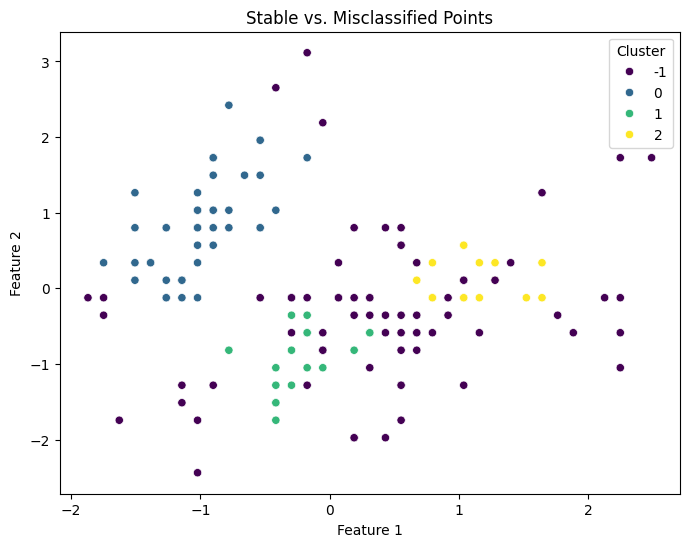

In [8]:
# Split stable and misclassified points
print("Splitting stable and misclassified points...")
stable_data, stable_labels, misclassified_data, misclassified_labels = split_stable_and_misclassified(
    data=pd.DataFrame(data),  # Ensure input is a DataFrame
    labels=pd.Series(cluster_labels, name="Cluster"),
    centroids=centroids,
    threshold=0.4
)


# Combine data and labels for visualization
combined_data = pd.concat([stable_data, misclassified_data])
combined_labels = pd.concat([stable_labels, misclassified_labels])

# Visualize stable and misclassified points
print("Visualizing stable and misclassified points...")
plot_clusters(
    combined_data,
    combined_labels,
    title="Stable vs. Misclassified Points",
    output_path="../results/iris/stable_vs_misclassified.png"
)


In [9]:
data[cluster_labels != original_labels]

,0,1,2,3
50,1.401508,0.337848,0.535296,0.264699
51,0.674501,0.337848,0.421564,0.396172
52,1.280340,0.106445,0.649027,0.396172
56,0.553333,0.569251,0.535296,0.527645
65,1.038005,0.106445,0.364699,0.264699
70,0.068662,0.337848,0.592162,0.790591
75,0.916837,-0.124958,0.364699,0.264699
76,1.159173,-0.587764,0.592162,0.264699
77,1.038005,-0.124958,0.705893,0.659118
85,0.189830,0.800654,0.421564,0.527645


In [10]:
misclassified_data

,0,1,2,3
8,-1.748856,-0.356361,-1.341272,-1.312977
13,-1.870024,-0.124958,-1.511870,-1.444450
14,-0.052506,2.189072,-1.455004,-1.312977
15,-0.173674,3.114684,-1.284407,-1.050031
33,-0.416010,2.651878,-1.341272,-1.312977
...,...,...,...,...
138,0.189830,-0.124958,0.592162,0.790591
142,-0.052506,-0.819166,0.762759,0.922064
146,0.553333,-1.281972,0.705893,0.922064
148,0.432165,0.800654,0.933356,1.447956


In [11]:
set(data[cluster_labels != original_labels].index).symmetric_difference(set(misclassified_data.index)).__len__()

46

In [12]:
set(data[cluster_labels != original_labels].index).difference(set(misclassified_data.index)).__len__()

1

Running Random Forest for post-processing...
Visualizing post-processed clustering results...


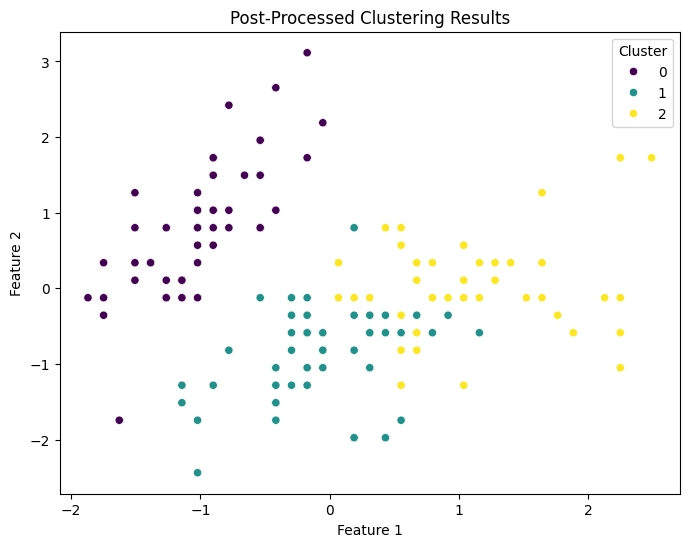

In [13]:
# Run post-processing and calculate metrics
if not misclassified_data.empty:
    print("Running Random Forest for post-processing...")
    updated_labels = post_process_with_rf(
        stable_data, stable_labels,
        misclassified_data,
    )

    # Update cluster_labels with the post-processed labels
    cluster_labels.update(updated_labels)

# Visualize post-processed clustering results
print("Visualizing post-processed clustering results...")
plot_clusters(data, cluster_labels, "Post-Processed Clustering Results", "../results/iris/post_processed.png")


In [14]:
# Calculate Random Forest metrics
rf_metrics = calculate_metrics(original_labels, cluster_labels)
print(f"Random Forest Metrics: {rf_metrics}")

Random Forest Metrics: {'precision': 0.8734160330798985, 'recall': 0.8733333333333333, 'accuracy': 0.8733333333333333}


In [15]:
# Consolidate metrics
metrics_dict = {
    "K-Means": kmeans_metrics,
    "Random Forest": rf_metrics
}

display_and_save_metrics_table(metrics_dict, "../results/iris/metrics.png")

Metrics table saved to ../results/iris/metrics.png
